# Visualizing the mouse behavior

In [77]:
import sys
sys.path.append('/Users/Sabatini Lab/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/Sabatini Lab/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
import sklearn.tree
import sys
import os
%matplotlib inline 

## load in csv files (from running exportTrials.m)

In [78]:
data = pd.read_csv('/Users/Sabatini Lab/GitHub/mouse_bandit/data/mike_data/trial_data/all_8020_high.csv',index_col=0)

In [79]:
data.tail(10)

Mouse ID      Session ID  Trial  Block Trial  Block Reward  Port Streak  \
674    SOM42  07282017_SOM42  685.0          7.0           5.0          8.0   
675    SOM42  07282017_SOM42  686.0          8.0           6.0          9.0   
676    SOM42  07282017_SOM42  687.0          9.0           7.0         10.0   
677    SOM42  07282017_SOM42  688.0         10.0           7.0         11.0   
678    SOM42  07282017_SOM42  689.0         11.0           8.0         12.0   
679    SOM42  07282017_SOM42  690.0         12.0           9.0         13.0   
680    SOM42  07282017_SOM42  691.0         13.0           9.0         14.0   
681    SOM42  07282017_SOM42  692.0         14.0          10.0         15.0   
682    SOM42  07282017_SOM42  693.0         15.0          11.0         16.0   
683    SOM42  07282017_SOM42  694.0         16.0          11.0         17.0   

     Reward Streak  10_Port  10_Reward  10_ITI   ...    1_Port  1_Reward  \
674            5.0    0.336        1.0     1.0   ...     0.286       0.0   
675            6.0    0.553        1.0     0.0   ...     0.536       0.0   
676            7.0    0.534        0.0     1.0   ...     0.336       0.0   
677           -1.0    0.491        0.0     1.0   ...     0.553       0.0   
678            1.0    0.547        0.0     0.0   ...     0.534       0.0   
679            2.0    0.699        0.0     1.0   ...     0.491       0.0   
680           -1.0    0.608        0.0     1.0   ...     0.547       0.0   
681            1.0    0.860        0.0     1.0   ...     0.699       0.0   
682            2.0    0.307        0.0     1.0   ...     0.608       0.0   
683           -1.0    0.346        0.0     1.0   ...     0.860       0.0   

     1_ITI  1_trialDuration  0_ITI  0_trialDuration  Decision  Switch  \
674    1.0            1.999  0.536            2.156       0.0     0.0   
675    1.0            2.156  0.336            3.498       0.0     0.0   
676    1.0            3.498  0.553            1.426       0.0     0.0   
677    0.0            1.426  0.534            1.818       0.0     0.0   
678    1.0            1.818  0.491            1.381       0.0     0.0   
679    1.0            1.381  0.547            1.922       0.0     0.0   
680    0.0            1.922  0.699            1.582       0.0     0.0   
681    1.0            1.582  0.608            1.962       0.0     0.0   
682    1.0            1.962  0.860            3.833       0.0     0.0   
683    0.0            3.833  0.307            2.754       0.0     0.0   

     Higher p port  Reward  
674            1.0     1.0  
675            1.0     1.0  
676            1.0     0.0  
677            1.0     1.0  
678            1.0     1.0  
679            1.0     0.0  
680            1.0     1.0  
681            1.0     1.0  
682            1.0     0.0  
683            1.0     0.0  

[10 rows x 53 columns]

In [80]:
data.shape


(8905, 53)

In [81]:
np.unique(data['Reward Streak'])

array([-19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
        -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   1.,   2.,   3.,
         4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
        26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        37.])

In [82]:
data['Reward'].mean()

0.68298708590679391

In [83]:
data[data['Reward Streak'] == -1]['Switch'].mean()

0.21234240212342403

## separate back into individual mice for mouse to mouse comparison

In [84]:
np.unique(data['Mouse ID'])

array(['PV30', 'SOM42'], dtype=object)

In [85]:
data_SOM42 = data[data['Mouse ID'] == 'SOM42']
data_PV30 = data[data['Mouse ID'] == 'PV30']
#data_SOM41 = data[data['Mouse ID'] == 'SOM41']
#data_SOM44 = data[data['Mouse ID'] == 'SOM44']
#data_SOM45 = data[data['Mouse ID'] == 'SOM45']
datas = []

for s in np.unique(data['Session ID'].values):
    datas.append(data_PV30[data_PV30['Session ID'] == s])
    datas.append(data_SOM42[data_SOM42['Session ID'] == s])
  #  datas.append(data_SOM41[data_SOM41['Session ID'] == s])
   # datas.append(data_SOM44[data_SOM44['Session ID'] == s])
    #datas.append(data_SOM45[data_SOM45['Session ID'] == s])

In [86]:
data_PV30.shape, data_SOM42.shape#, data_SOM41.shape, data_SOM44.shape, data_SOM45.shape

((5761, 53), (3144, 53))

# p(switch) | switched in ith previous trial

In [59]:
p_switch = np.zeros(20)
for i in np.arange(0,20):
    p_switch[i] = data.iloc[np.where(data['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [60]:
p_switchy = np.zeros((len(datas),20))

for s,d in enumerate(datas):
    for i in np.arange(0,20):
        p_switchy[s,i] = d.iloc[np.where(d['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [61]:
errors = p_switchy.std(axis=0) / np.sqrt(len(p_switchy))

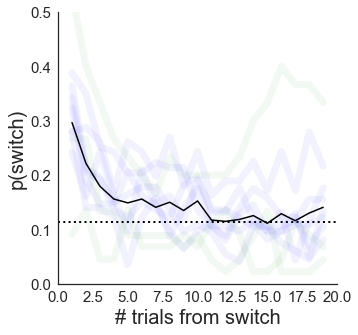

In [62]:
sns.set_style('white')
plt.figure(figsize=(5,5))
for s in range(20):
    if (s%2 == 0):
        plt.plot(np.arange(1,20),p_switchy[s,1:],alpha=0.05,linewidth=7,color='blue')
    else:
        plt.plot(np.arange(1,20),p_switchy[s,1:],alpha=0.05,linewidth=7,color='green')
        
plt.hlines(y=data['Switch'].mean(axis=0),xmin=0,xmax=20,color='black',alpha=1,linewidth=2,linestyles='dotted',label='average')
plt.plot(np.arange(1,20),p_switch[1:],color='black',linewidth=1.5)
plt.fill_between(np.arange(1,20),p_switch[1:]+errors[1:],p_switch[1:]-errors[1:],color='grey')
plt.xlim(0,20)
plt.ylim(0,0.5)
plt.xlabel('# trials from switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

# Looking more closely at the switch trials

In [24]:
switches = data['Switch'].values

In [25]:
streak = np.array([3,2,1,-1,-2,-3,-4,-5,-6,-7,-8])
port_streaks = np.arange(0,6)
p_switch_a = np.zeros_like(streak)*0.0
p_switch_b = np.zeros_like(streak)*0.0

for i,s in enumerate(streak): 
        p_switch_a[i] = data[(data['Port Streak'] >= 5) & (data['Reward Streak'] == s)]['Switch'].mean()
        p_switch_b[i] = data[(data['Port Streak'] < 5) & (data['Reward Streak'] == s)]['Switch'].mean()

In [26]:
streak = np.array([3,2,1,-1,-2,-3,-4,-5,-6,-7,-8])
port_streaks = np.arange(0,6)
p_switch_indi_a = np.zeros((len(datas),streak.shape[0]))
p_switch_indi_b = np.zeros_like(p_switch_indi_a)

for j,d in enumerate(datas):
    for i,s in enumerate(streak): 
            p_switch_indi_a[j,i] = d[(d['Port Streak'] >= 5) & (d['Reward Streak'] == s)]['Switch'].mean()
            p_switch_indi_b[j,i] = d[(d['Port Streak'] < 5) & (d['Reward Streak'] == s)]['Switch'].mean()

In [27]:
errors_a = np.nanstd(p_switch_indi_a,axis=0) / np.sqrt(p_switch_indi_a.shape[0])
errors_b = np.nanstd(p_switch_indi_b,axis=0) / np.sqrt(p_switch_indi_a.shape[0])

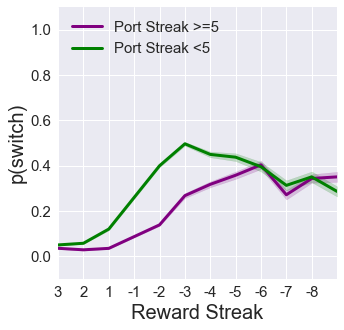

In [28]:
plt.figure(figsize=(5,5))
#plt.vlines(x=0,ymin=0,ymax=1,color='white',linewidth=60,zorder=3)
plt.plot(streak,p_switch_a,label='Port Streak >=5',linewidth=3,zorder=1,color='purple')
plt.fill_between(streak,p_switch_a+errors_a,p_switch_a-errors_a,color='purple',alpha=0.2)
plt.plot(streak,p_switch_b,label='Port Streak <5',linewidth=3,zorder=2,color='green')
plt.fill_between(streak,p_switch_b+errors_b,p_switch_b-errors_b,color='green',alpha=0.2)
plt.xticks(np.arange(3,-8,-1),streak,fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(3,-8)
plt.ylim(-0.1,1.1)
plt.legend(loc='upper left',fontsize=15)
sns.despine()
plt.ylabel('p(switch)',fontsize=20)
plt.xlabel('Reward Streak',fontsize=20)

# Switches when 1_Reward = 0

(0, 0.5)

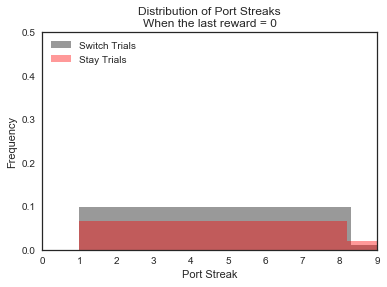

In [50]:
plt.hist(data[(data['1_Reward'] == 0) & (data['Switch'] == 1)]['Port Streak'],color='black',alpha=0.4,normed=True,label='Switch Trials')
plt.hist(data[(data['1_Reward'] == 0) & (data['Switch'] == 0)]['Port Streak'],color='red',alpha=0.4,normed=True,label='Stay Trials')
plt.title('Distribution of Port Streaks\nWhen the last reward = 0')
plt.ylabel('Frequency')
plt.xlabel('Port Streak')
plt.legend(loc='upper left')
plt.xlim(0,9)
plt.ylim(0,0.5)

(array([  5.46083029e-02,   2.66600388e-02,   1.80830441e-02,
          1.30402884e-02,   9.45815997e-03,   8.20345723e-03,
          5.23431334e-03,   2.96435495e-03,   5.65095128e-04,
          7.18341264e-05]),
 array([  1. ,   8.2,  15.4,  22.6,  29.8,  37. ,  44.2,  51.4,  58.6,
         65.8,  73. ]),
 <a list of 10 Patch objects>)

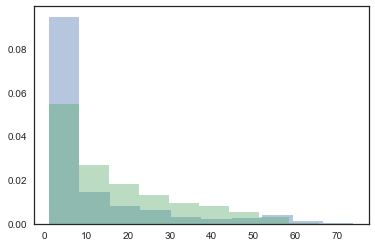

In [52]:
plt.hist(data[data['Switch']==1]['Port Streak'],normed=True,alpha=0.4)
plt.hist(data[data['Switch']==0]['Port Streak'],normed=True,alpha=0.4)

(array([  5.46083029e-02,   2.66600388e-02,   1.80830441e-02,
          1.30402884e-02,   9.45815997e-03,   8.20345723e-03,
          5.23431334e-03,   2.96435495e-03,   5.65095128e-04,
          7.18341264e-05]),
 array([  1. ,   8.2,  15.4,  22.6,  29.8,  37. ,  44.2,  51.4,  58.6,
         65.8,  73. ]),
 <a list of 10 Patch objects>)

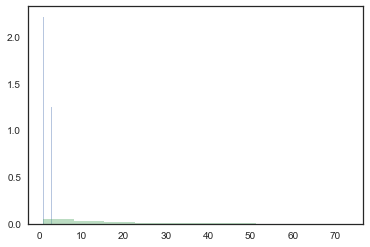

In [53]:
plt.hist(data[data['Port Streak'] <= 3]['Port Streak'],normed=True,alpha=0.4)
plt.hist(data[data['Switch']==0]['Port Streak'],normed=True,alpha=0.4)

In [54]:
data[data['Port Streak'] > 5]['Switch'].mean()

0.056844390177723511

In [55]:
p_switch

array([ 1.        ,  0.30268199,  0.18965517,  0.16123883,  0.15070243,
        0.1408046 ,  0.1302682 ,  0.13537676,  0.13473819,  0.12484036,
        0.12356322,  0.12100894,  0.12228608,  0.12005109,  0.12452107,
        0.12867178,  0.11813538,  0.1155811 ,  0.11909323,  0.1197318 ])

In [56]:
p_switch = np.zeros(10)*0.0
avg = data['Switch'].mean()

for i,s in enumerate(np.arange(1,11)):
    p_switch[i] = data[data['Port Streak'] == s]['Switch'].mean()

p_switches = np.zeros((20,10))*0.0
p_switches_R = np.zeros((20,10))*0.0
p_switches_nR = np.zeros((20,10))*0.0
for j,d in enumerate(datas):
    for i,s in enumerate(np.arange(1,11)):
        p_switches[j,i] = d[d['Port Streak'] == s]['Switch'].mean()
        p_switches_R[j,i] = d[(d['Port Streak'] == s) & (d['1_Reward']==1)]['Switch'].mean()
        p_switches_nR[j,i] = d[(d['Port Streak'] == s) & (d['1_Reward']==0)]['Switch'].mean()

errors = p_switches.std(axis=0) / np.sqrt(p_switches.shape[0])
errors_R = np.nanstd(p_switches_R,axis=0) / np.sqrt(p_switches.shape[0])
errors_nR = np.nanstd(p_switches_nR,axis=0) / np.sqrt(p_switches.shape[0])
p_switch_R = np.nanmean(p_switches_R,axis=0)
p_switch_nR = np.nanmean(p_switches_nR,axis=0)

IndexError: index 20 is out of bounds for axis 0 with size 20

ValueError: operands could not be broadcast together with shapes (10,) (20,) 

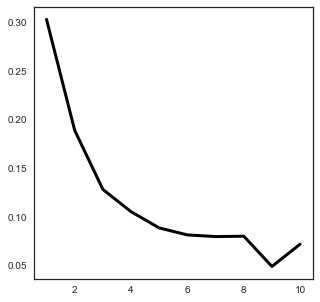

In [57]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1,11),p_switch,color='black',linewidth=3,label='All Trials')
plt.fill_between(np.arange(1,11),p_switch+errors,p_switch-errors,color='black',alpha=0.5)

plt.plot(np.arange(1,11),p_switch_R,color='green',linewidth=3,label='Previous Trial Rewarded')
plt.fill_between(np.arange(1,11),p_switch_R+errors_R,p_switch_R-errors_R,color='green',alpha=0.5)

plt.plot(np.arange(1,11),p_switch_nR,color='blue',linewidth=3,label='Previous Trial Not Rewarded')
plt.fill_between(np.arange(1,11),p_switch_nR+errors_nR,p_switch_nR-errors_nR,color='blue',alpha=0.5)

plt.hlines(y=avg,xmin=1,xmax=10,linestyle='dotted')
plt.ylim(0,0.7)
plt.ylabel('p(switch)',fontsize=20)
plt.xlabel('# trials since previous switch',fontsize=20)
plt.legend(loc='upper right',fontsize=15)
plt.xticks(np.arange(1,11),[0,1,2,3,4,5,6,7,8,'>8','>9'],fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

In [58]:
c = 0
cs = np.zeros(10)
for j,i in enumerate(np.arange(1,11)):
    c +=  data[data['Port Streak'] == i]['Switch'].sum()/data['Switch'].sum()
    cs[j] = c

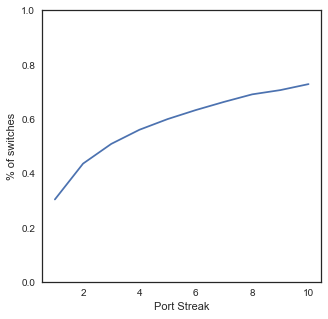

In [59]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11),cs)
plt.ylim(0,1)
plt.ylabel('% of switches')
plt.xlabel('Port Streak')

## analysis of block switches

In [87]:
data.shape

(8905, 53)

In [88]:
t_block_unique = np.unique(data['Block Trial'].values)
p_switch_block = np.zeros((t_block_unique.shape[0],2))
high_p_port = np.zeros_like(p_switch_block)
trial_block_count = np.zeros_like(t_block_unique)

for t in t_block_unique:
    p_switch_block[int(t),0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
    trial_block_count[int(t)] = data[data['Block Trial'] == t].shape[0]
    p_switch_block[int(t),1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[int(t)])
    
    high_p_port[int(t),0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
    high_p_port[int(t),1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[int(t)])
    

total # of blocks in dataset: ~119


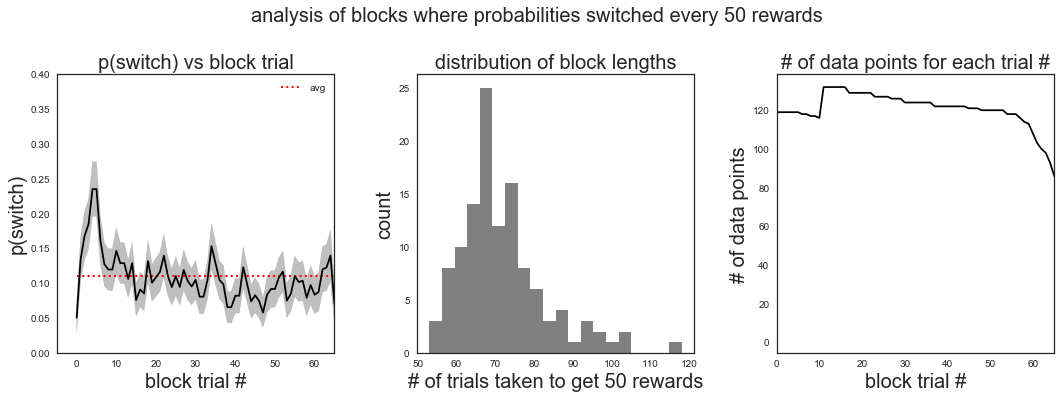

In [89]:
x_end=65
plt.figure(figsize=(15,5))
plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

plt.subplot(131)
plt.plot(t_block_unique,p_switch_block[:,0],color='black')
plt.fill_between(t_block_unique,p_switch_block[:,0]+p_switch_block[:,1],p_switch_block[:,0]-p_switch_block[:,1],color='grey',alpha=0.5)
plt.hlines(data['Switch'].mean(axis=0),xmin=0,xmax=x_end,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlim(-5,x_end)
plt.ylim(0,0.4)
plt.xlabel('block trial #',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) vs block trial',fontsize=20)

plt.subplot(132)
plt.hist(data.iloc[np.where(data['Block Trial']==0)[0]-1]['Block Trial'],bins=20,color='grey')
plt.title('distribution of block lengths',fontsize=20)
plt.xlabel('# of trials taken to get 50 rewards',fontsize=20)
plt.ylabel('count',fontsize=20)

plt.subplot(133)
plt.plot(t_block_unique,trial_block_count,color='black')
plt.title('# of data points for each trial #',fontsize=20)
plt.ylabel('# of data points',fontsize=20)
plt.xlabel('block trial #',fontsize=20)
plt.xlim(0,x_end)

plt.tight_layout()
print('total # of blocks in dataset: ~%.0f' % (np.sum(data['Block Trial']==0)))

In [90]:
data.index = np.arange(data.shape[0])

In [91]:
data.tail(10)

Mouse ID      Session ID  Trial  Block Trial  Block Reward  Port Streak  \
8895    SOM42  07282017_SOM42  685.0          7.0           5.0          8.0   
8896    SOM42  07282017_SOM42  686.0          8.0           6.0          9.0   
8897    SOM42  07282017_SOM42  687.0          9.0           7.0         10.0   
8898    SOM42  07282017_SOM42  688.0         10.0           7.0         11.0   
8899    SOM42  07282017_SOM42  689.0         11.0           8.0         12.0   
8900    SOM42  07282017_SOM42  690.0         12.0           9.0         13.0   
8901    SOM42  07282017_SOM42  691.0         13.0           9.0         14.0   
8902    SOM42  07282017_SOM42  692.0         14.0          10.0         15.0   
8903    SOM42  07282017_SOM42  693.0         15.0          11.0         16.0   
8904    SOM42  07282017_SOM42  694.0         16.0          11.0         17.0   

      Reward Streak  10_Port  10_Reward  10_ITI   ...    1_Port  1_Reward  \
8895            5.0    0.336        1.0     1.0   ...     0.286       0.0   
8896            6.0    0.553        1.0     0.0   ...     0.536       0.0   
8897            7.0    0.534        0.0     1.0   ...     0.336       0.0   
8898           -1.0    0.491        0.0     1.0   ...     0.553       0.0   
8899            1.0    0.547        0.0     0.0   ...     0.534       0.0   
8900            2.0    0.699        0.0     1.0   ...     0.491       0.0   
8901           -1.0    0.608        0.0     1.0   ...     0.547       0.0   
8902            1.0    0.860        0.0     1.0   ...     0.699       0.0   
8903            2.0    0.307        0.0     1.0   ...     0.608       0.0   
8904           -1.0    0.346        0.0     1.0   ...     0.860       0.0   

      1_ITI  1_trialDuration  0_ITI  0_trialDuration  Decision  Switch  \
8895    1.0            1.999  0.536            2.156       0.0     0.0   
8896    1.0            2.156  0.336            3.498       0.0     0.0   
8897    1.0            3.498  0.553            1.426       0.0     0.0   
8898    0.0            1.426  0.534            1.818       0.0     0.0   
8899    1.0            1.818  0.491            1.381       0.0     0.0   
8900    1.0            1.381  0.547            1.922       0.0     0.0   
8901    0.0            1.922  0.699            1.582       0.0     0.0   
8902    1.0            1.582  0.608            1.962       0.0     0.0   
8903    1.0            1.962  0.860            3.833       0.0     0.0   
8904    0.0            3.833  0.307            2.754       0.0     0.0   

      Higher p port  Reward  
8895            1.0     1.0  
8896            1.0     1.0  
8897            1.0     0.0  
8898            1.0     1.0  
8899            1.0     1.0  
8900            1.0     0.0  
8901            1.0     1.0  
8902            1.0     1.0  
8903            1.0     0.0  
8904            1.0     0.0  

[10 rows x 53 columns]

In [92]:
switch_points = data[data['Block Trial'] == 0 ].index.values

In [93]:
switch_points = data[data['Block Trial'] == 0 ].index.values

L = 15
paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
paraswitch_port = np.zeros_like(paraswitch)

for i,point in enumerate(switch_points):

    paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
    paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port']
# if final block ends before 40 trials will show error "could not broadcast input array from shape (26) into shape (40)"

ValueError: could not broadcast input array from shape (32) into shape (40)

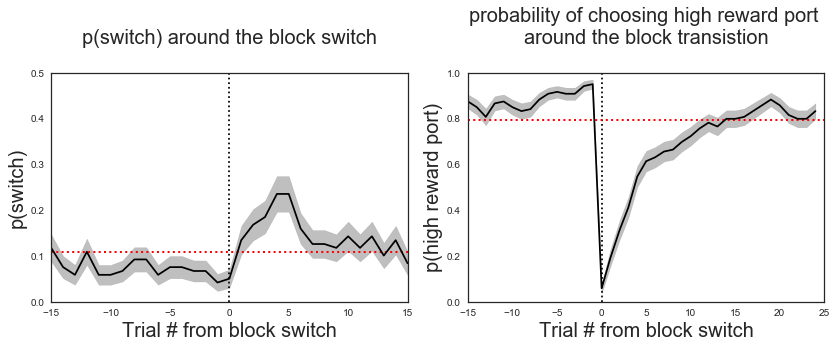

In [94]:
u = paraswitch.mean(axis=0)
s = paraswitch.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+1,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.5)

plt.subplot(122)
u = paraswitch_port.mean(axis=0)
s = paraswitch_port.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(data['Higher p port'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the block transistion',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,1)

plt.tight_layout()

## look at individual mice, smarter

In [95]:
data_SOM42 = data[data['Mouse ID'] == 'SOM42']
data_PV30 = data[data['Mouse ID'] == 'PV30']
#data_SOM41 = data[data['Mouse ID'] == 'SOM41']
#data_SOM44 = data[data['Mouse ID'] == 'SOM44']
#data_SOM45 = data[data['Mouse ID'] == 'SOM45']


In [96]:
mice = [data_PV30, data_SOM42]

ValueError: could not broadcast input array from shape (32) into shape (40)

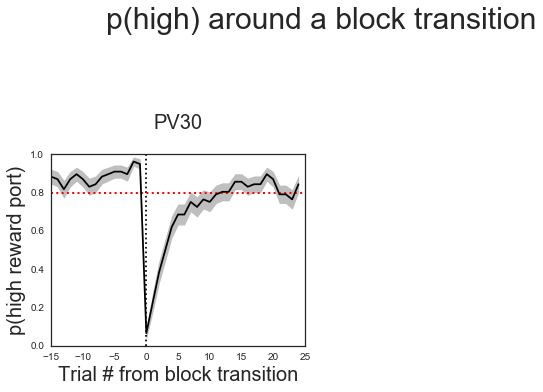

In [97]:
fig = plt.figure(figsize=(10,12))
plt.suptitle('p(high) around a block transition',x=0.5,y=1.05,fontsize=30)

for i,mouse in enumerate(mice):

    switch_points = mouse[mouse['Block Trial'] == 0 ].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for j,point in enumerate(switch_points):

        paraswitch[j,:] = data.iloc[point-L:point+L+10]['Switch']
        paraswitch_port[j,:] = data.iloc[point-L:point+L+10]['Higher p port'] 
        
    plt.subplot(3,2,i+1)
    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color='black')
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
    plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
    plt.hlines(data['Higher p port'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
    plt.xlabel('Trial # from block transition',fontsize=20)
    plt.ylabel('p(high reward port)',fontsize=20)
    plt.title(mouse['Mouse ID'].values[0], fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L+10)
    plt.ylim(0,1)
        
plt.tight_layout()

In [98]:
data_PV30.shape, data_SOM42.shape

((5761, 53), (3144, 53))

ValueError: could not broadcast input array from shape (32) into shape (40)

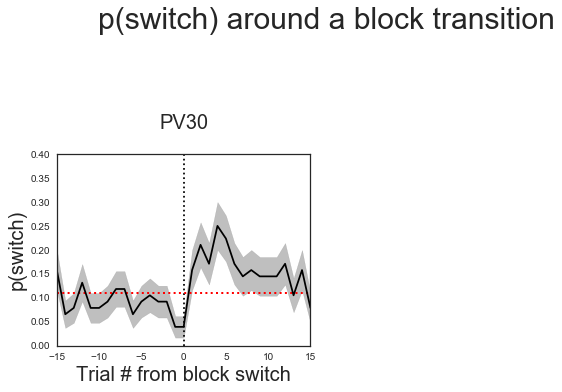

In [99]:
fig = plt.figure(figsize=(10,12))
plt.suptitle('p(switch) around a block transition',x=0.5,y=1.05,fontsize=30)

for i,mouse in enumerate(mice):

    switch_points = mouse[mouse['Block Trial'] == 0 ].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for j,point in enumerate(switch_points):

        paraswitch[j,:] = data.iloc[point-L:point+L+10]['Switch']
        paraswitch_port[j,:] = data.iloc[point-L:point+L+10]['Switch'] 
        
    plt.subplot(3,2,i+1)
    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color='black')
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
    plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
    plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+1,color='red',linestyle='dotted',label='avg',linewidth=2)
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(switch)',fontsize=20)
    plt.title(mouse['Mouse ID'].values[0],fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L)
    plt.ylim(0,0.4)
        
plt.tight_layout()


## END

## Looking at p(switch) after rewarded or nonrewarded trials

In [33]:
switch_points = data[data['Block Trial'] == 0 ].index.values
switch_points

array([   52,   129,   218,   290,   362,   430,   509,   600,   667,
         731,   803,   875,   946,  1015,  1098,  1209,  1276,  1344,
        1406,  1476,  1554,  1642,  1718,  1845,  1907,  1969,  2023,
        2090,  2167,  2232,  2308,  2397,  2477,  2546,  2627,  2695,
        2774,  2842,  2907,  2991,  3050,  3134,  3192,  3268,  3330,
        3400,  3470,  3532,  3606,  3686,  3750,  3824,  3901,  3988,
        4070,  4148,  4235,  4317,  4391,  4456,  4520,  4581,  4647,
        4767,  4827,  4919,  4991,  5056,  5128,  5199,  5316,  5389,
        5462,  5534,  5605,  5674,  5734,  5803,  5924,  5994,  6076,
        6152,  6223,  6304,  6367,  6424,  6493,  6564,  6632,  6696,
        6766,  6828,  6898,  6954,  7024,  7098,  7164,  7224,  7293,
        7359,  7482,  7549,  7618,  7704,  7776,  7855,  7924,  8051,
        8131,  8200,  8266,  8338,  8413,  8490,  8559,  8667,  8741,
        8807,  8900,  8967,  9062,  9122,  9213,  9280,  9344,  9405,
        9475,  9551,

little note on the for loop below. 

took me little while because I had the order of the else-if statements wrong. 

when block_trial == 0 needs to come BEFORE whether the block trial incremented by 1 or not (which is my hokey way of detecting when a new session started where block_trial does not equal 0. 

I suppose a better way would be to detect when the block trial is 11 AND the previous block trial != 10. that would work. okay. switched it to that now. 

In [72]:
block_reward = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    trial = data.iloc[i]
    
    #lets deal with weird cases first:
    #1) the first row
    if(i == 0):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    
    #3) the first trial of a new block
    elif (trial['Block Trial'] == 0):
        block_reward[i] = 0
    
    #2) the first trial of a new session
    elif (((trial['Block Trial'] - trial_prev['Block Trial']) != 1) and (trial['Block Trial'] == 11)):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    else:
        block_reward[i] = block_reward[i-1] + trial['Reward']
    
    trial_prev = trial

In [73]:
reward_switches = np.zeros(np.unique(block_reward).shape[0])
reward_switches_afterR = np.zeros(np.unique(block_reward).shape[0])
reward_switches_afterNoR = np.zeros(np.unique(block_reward).shape[0])
for i,r_block in enumerate(np.unique(block_reward)):
    reward_switches[i] = data[block_reward == r_block]['Switch'].mean()
    reward_switches_afterR[i] = data[((block_reward == r_block) & (data['1_Reward']==1))]['Switch'].mean()
    reward_switches_afterNoR[i] = data[((block_reward == r_block) & (data['1_Reward']==0))]['Switch'].mean()

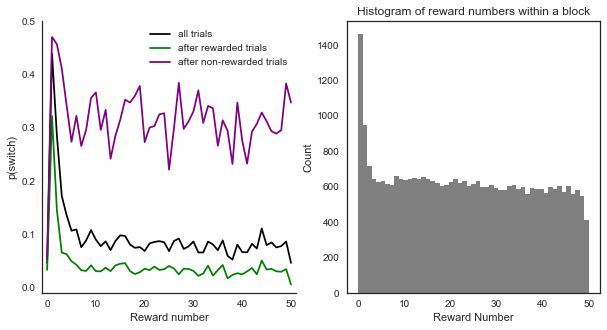

In [74]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.unique(block_reward),reward_switches,color='black',label='all trials')
plt.plot(np.unique(block_reward),reward_switches_afterR,color='green',label='after rewarded trials')
plt.plot(np.unique(block_reward),reward_switches_afterNoR,color='purple',label='after non-rewarded trials')
plt.xlabel('Reward number')
plt.ylabel('p(switch)')
plt.legend(loc='upper right')
plt.xlim(-1,51)
plt.ylim(-0.01,0.5)
sns.despine()

plt.subplot(122)
plt.hist(block_reward,bins=51,color='grey')
plt.title('Histogram of reward numbers within a block')
plt.xlabel('Reward Number')
plt.ylabel('Count')

In [75]:
data

Mouse ID      Session ID  Block Trial  Port Streak  Reward Streak  \
0        SOM42  06142017_SOM42           11            2             -1   
1        SOM42  06142017_SOM42           12            3              1   
2        SOM42  06142017_SOM42           13            4              2   
3        SOM42  06142017_SOM42           14            5              3   
4        SOM42  06142017_SOM42           15            6              4   
5        SOM42  06142017_SOM42           16            7              5   
6        SOM42  06142017_SOM42           17            8              6   
7        SOM42  06142017_SOM42           18            9              7   
8        SOM42  06142017_SOM42           19           10              8   
9        SOM42  06142017_SOM42           20           11              9   
10       SOM42  06142017_SOM42           21           12             10   
11       SOM42  06142017_SOM42           22           13             11   
12       SOM42  06142017_SOM42           23           14             12   
13       SOM42  06142017_SOM42           24           15             -1   
14       SOM42  06142017_SOM42           25           16              1   
15       SOM42  06142017_SOM42           26           17              2   
16       SOM42  06142017_SOM42           27           18              3   
17       SOM42  06142017_SOM42           28           19              4   
18       SOM42  06142017_SOM42           29           20              5   
19       SOM42  06142017_SOM42           30           21              6   
20       SOM42  06142017_SOM42           31           22              7   
21       SOM42  06142017_SOM42           32           23              8   
22       SOM42  06142017_SOM42           33           24              9   
23       SOM42  06142017_SOM42           34           25             10   
24       SOM42  06142017_SOM42           35           26             11   
25       SOM42  06142017_SOM42           36           27             12   
26       SOM42  06142017_SOM42           37           28             13   
27       SOM42  06142017_SOM42           38           29             14   
28       SOM42  06142017_SOM42           39           30             15   
29       SOM42  06142017_SOM42           40           31             16   
...        ...             ...          ...          ...            ...   
32104    SOM42  07172017_SOM42            7            1             -1   
32105    SOM42  07172017_SOM42            8            1              1   
32106    SOM42  07172017_SOM42            9            2              2   
32107    SOM42  07172017_SOM42           10            3             -1   
32108    SOM42  07172017_SOM42           11            4              1   
32109    SOM42  07172017_SOM42           12            5              2   
32110    SOM42  07172017_SOM42           13            6              3   
32111    SOM42  07172017_SOM42           14            7              4   
32112    SOM42  07172017_SOM42           15            8             -1   
32113    SOM42  07172017_SOM42           16            9              1   
32114    SOM42  07172017_SOM42           17           10              2   
32115    SOM42  07172017_SOM42           18           11              3   
32116    SOM42  07172017_SOM42           19           12             -1   
32117    SOM42  07172017_SOM42           20           13              1   
32118    SOM42  07172017_SOM42           21           14              2   
32119    SOM42  07172017_SOM42           22           15              3   
32120    SOM42  07172017_SOM42           23           16              4   
32121    SOM42  07172017_SOM42           24           17              5   
32122    SOM42  07172017_SOM42           25           18              6   
32123    SOM42  07172017_SOM42           26           19              7   
32124    SOM42  07172017_SOM42           27           20              8   
32125    SOM42  07172017_SOM42 